In [ ]:
#!pip install rasterio
#!pip install rioxarray
#!pip install shapely
#!pip install matplotlib
#!pip install geopandas
#!pip install fiona

In [1]:
import rasterio as rio
import rioxarray as rxray
from rasterio.merge import merge
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.plot import reshape_as_image

from rasterio.crs import CRS
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint
from rasterio.warp import calculate_default_transform, reproject, Resampling

from shapely.geometry import shape
import matplotlib.pyplot as plt
import geopandas as gpd
import fiona
import numpy as np
import shutil
import re
import os

In [ ]:
#Capture images within subfolders - Might use them for another process

destination_folder = "C:\\Users\\jullian.williams\\Desktop\\HIRLOMAP\\capture_einc_S1\\"
main_folder = "C:\\Users\\jullian.williams\\Desktop\\HIRLOMAP\\S1\\"

# Loop through all subfolders and files
for subdir, _, files in os.walk(main_folder):
    for file in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if file.endswith(('einc.tif')):
            file_path = os.path.join(subdir, file)
            destination_file = os.path.join(destination_folder, file)
            shutil.copy(file_path, destination_file)
            print("Images copied successfully!")

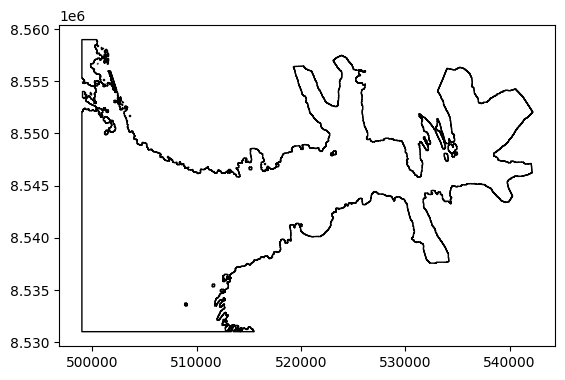

In [5]:
mask08 = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/hornsund_zmail/2008_vector/landmaskM2_2008_buffer_100_10m.gpkg'
mask08_shp = gpd.read_file(mask08)

# Plot the shape
mask08_shp.plot(edgecolor ='black', facecolor = 'None');

In [28]:
with fiona.open('C:/Users/jullian.williams/Desktop/HIRLOMAP/hornsund_zmail/2008_vector/landmaskM2_2008_buffer_100_10m.gpkg', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [30]:
overlay_image = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/capture_einc_RS2/RS2_SCNA_20120203_155203_ASC_001_einc.tif'
overlay = rio.open(overlay_image)
oimg = overlay.read()

In [33]:
print(oimg)

[[[35.99509  35.997776 36.000458 ... 38.333725 38.336243 38.338745]
  [35.994133 35.99682  35.999504 ... 38.33282  38.33531  38.33781 ]
  [35.99318  35.995865 35.998547 ... 38.331917 38.334396 38.336884]
  ...
  [35.45896  35.461674 35.464386 ... 37.820305 37.82369  37.826977]
  [35.457996 35.46071  35.46342  ... 37.819527 37.82287  37.82613 ]
  [35.457027 35.459743 35.462452 ... 37.81865  37.821953 37.825203]]]


In [34]:
import rioxarray
xds = rioxarray.open_rasterio('C:/Users/jullian.williams/Desktop/HIRLOMAP/capture_einc_RS2/RS2_SCNA_20120203_155203_ASC_001_einc.tif')
clipped = xds.rio.clip(shapes)

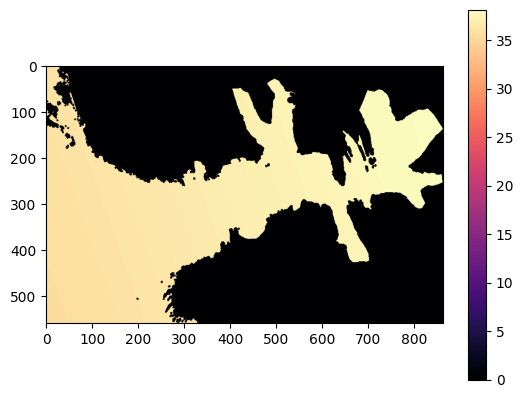

In [36]:
plt.imshow(clipped[0], cmap='magma')
plt.colorbar();

In [15]:
directory = "C:/Users/jullian.williams/Desktop/HIRLOMAP/capture_einc_RS2/"

# Get a list of all files in the directory
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.tif', '.tiff'))]

# Sort and select the first 5 files
first_5_files = sorted(files)[:4]

# Open and process the first 5 images
for file in first_5_files:
    with rio.open(file) as src:
        print(f"Opened: {file}")
        print(f"Width: {src.width}, Height: {src.height}, CRS: {src.crs}")
        # Example: Read the first band
        band1 = src.read(1)
        print(f"Band 1 shape: {band1.shape}")

Opened: C:/Users/jullian.williams/Desktop/HIRLOMAP/capture_einc_RS2/RS2_SCNA_20120203_155203_ASC_001_einc.tif
Width: 901, Height: 561, CRS: PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Band 1 shape: (561, 901)
Opened: C:/Users/jullian.williams/Desktop/HIRLOMAP/capture_einc_RS2/RS2_SCNA_20120214_153109_ASC_158_einc.tif
Width: 901, Height: 561, CRS: PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]]

In [69]:
#Clips image without maintaining georeferencing

# Directory containing .tif files
input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/RS2/2015/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/capture_einc_RS2_/"
shapefile_path = "C:/Users/jullian.williams/Desktop/HIRLOMAP/hornsund_zmail/vector/2015.shp"

# Load the shapefile for clipping
shapefile = gpd.read_file(shapefile_path)
geometries = [feature["geometry"] for feature in shapefile.__geo_interface__["features"]]

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('einc.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".tif"))


                # Open the SAR data file (e.g., GeoTIFF format)
            with rio.open(input_path) as src:
                # Read the data as a NumPy array
                sar_data = src.read()


                clipped_image, clipped_transform = mask(src, geometries, crop=True)
                clipped_meta = src.meta.copy()

                
                with rio.open(output_path, 'w', driver='GTIFF', height=clipped_image.shape[1],     
                width=clipped_image.shape[2], count=1, dtype=clipped_image.dtype) as dst:
                    dst.write(clipped_image)
                
print("Clipping completed!")

C:\Users\jullian.williams\.conda\envs\tf\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
C:\Users\jullian.williams\.conda\envs\tf\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
C:\Users\jullian.williams\.conda\envs\tf\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
C:\Users\jullian.williams\.conda\envs\tf\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


Clipping completed!


C:\Users\jullian.williams\.conda\envs\tf\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
C:\Users\jullian.williams\.conda\envs\tf\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
C:\Users\jullian.williams\.conda\envs\tf\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
C:\Users\jullian.williams\.conda\envs\tf\lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


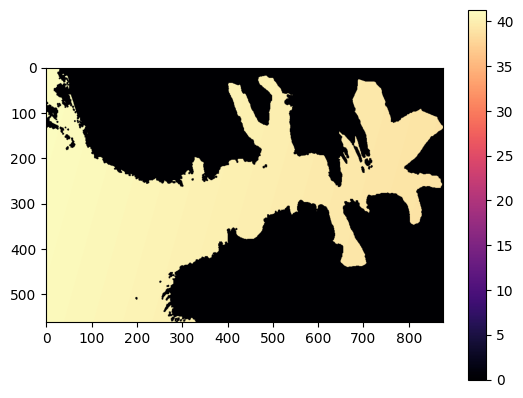

In [70]:
plt.imshow(clipped_image[0], cmap='magma')
plt.colorbar();

In [46]:
# Clip image and maintain georeferencing

input_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/S1/IW_2014_2022/2022/"
output_dir = "C:/Users/jullian.williams/Desktop/HIRLOMAP/capture_einc_S1_/IW/update/"
shapefile_path = 'C:/Users/jullian.williams/Desktop/HIRLOMAP/hornsund_zmail/vector/2022.shp'
#"C:/Users/jullian.williams/Desktop/HIRLOMAP/hornsund_zmail/vector/2015.shp"


# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through all .tif files in the input directory
for subdir, _, files in os.walk(input_dir):
    for filename in files: 
        # Check if the file is an image (e.g., .jpg, .png)
        if filename.endswith(('einc.tif')):
            input_path = os.path.join(subdir, filename)
            output_path = os.path.join(output_dir, filename.replace(".tif", ".tif"))


            # Load the shapefile for clipping
            shapefile = gpd.read_file(shapefile_path)
            geometries = [feature["geometry"] for feature in shapefile.__geo_interface__["features"]]
        
            with rio.open(input_path) as src:
            # Step 3: Clip the raster
                clipped_image, clipped_transform = mask(src, geometries, crop=True)
        
                # Save the clipped image
                clipped_meta = src.meta.copy()
                clipped_meta.update({
                    "driver": "GTiff",
                    "height": clipped_image.shape[1],
                    "width": clipped_image.shape[2],
                    "transform": clipped_transform
                })

                
                with rio.open(output_path, "w", **clipped_meta) as dst:
                    dst.write(clipped_image)
                
print(f"Clipped image saved to {output_path}")

Clipped image saved to C:/Users/jullian.williams/Desktop/HIRLOMAP/capture_einc_S1_/IW/update/S1_IWH_20230621_154510_ASC_014_einc.tif


In [15]:
# Just to change CRS
# Open the clipped image
with rio.open('C:/Users/jullian.williams/Desktop/HIRLOMAP/capture_einc_RS2_/RS2_SCWA_20120604_063534_DES_024_einc.tif', 'r+') as dst:
    # Define the desired projection (e.g., EPSG:4326 for WGS84)
    dst.crs = CRS.from_epsg(32633)  # Replace 4326 with your desired EPSG code

    # Save the changes
    print(f"Projection assigned: {dst.crs}")

Projection assigned: EPSG:32633


C:\Users\jullian.williams\.conda\envs\pyproj_env\Lib\site-packages\rasterio\__init__.py:370: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = get_writer_for_path(path, driver=driver)(
